# Santander Customer Transaction Prediction
At Santander our mission is to help people and businesses prosper. We are always looking for ways to help our customers understand their financial health and identify which products and services might help them achieve their monetary goals.

Our data science team is continually challenging our machine learning algorithms, working with the global data science community to make sure we can more accurately identify new ways to solve our most common challenge, binary classification problems such as: is a customer satisfied? Will a customer buy this product? Can a customer pay this loan?

In this challenge, we invite Kagglers to help us identify which customers will make a specific transaction in the future, irrespective of the amount of money transacted. The data provided for this competition has the same structure as the real data we have available to solve this problem.

**Note**:
Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.

### EDA and Simple Modeling

Before digging deep into the modeling aspect, I'd like to spend some time on this data set, and see if there is anything that might help in solving this particular problem. One of the very first things that is apparent is how imbalanced the data set is. Majority of the observations are negative (class 0), which suggests that the models should "pay more attention" to the positive samples (i.e. assign higher weights for the positive class). There is little I can infer from the correlation matrix, apart from the fact that none of the features are highly correlated with each other, which means that most of them (if not all) are important. If there were any features that would be redundant, there could be a possibility of performing PCA to reduce the dimensionality of the dataset.

**What about feature engineering?**

It would be very hard to perform feature engineering of any kind. All of these features are labeled in a way that nothing really can be infered/assumed. The only possibility that I see so far is to perform something called "Machine Learning EDA" and just see what the model (Random Forest for example) will output as important features, and then based on that perform some feature engineering.

Before any modeling, setting the hyperparameters, and all the "good stuff", let's read in the libraries used in this project.

**Note:** This notebook contains modeling performed using sklearn's models. However, my aim for this project is to also use PyTorch, and maybe somewhere down the line some unsupervised algorithms. But I am very interested what would be the output of some kind of a deep learning model (or a combination thereof).

In [3]:
# Data manipulation
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Logistic Regression
from sklearn.linear_model import LogisticRegression

# Random Forest
from sklearn.ensemble import RandomForestClassifier
import xgboost

# Preprocessing
from sklearn.preprocessing import StandardScaler

# Metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, confusion_matrix
from sklearn.metrics import log_loss

# Sklearn Model Selection 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import KFold
import joblib


# LightGBM
import lightgbm as lgb

/Users/januszpolowczyk/Documents/Santander/env/lib/python3.6/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [4]:
## Helper functions

def plot_ROC(fpr, tpr, thresholds, actuals, scores,  model = None):
    plt.figure(figsize = (10,5))
    plt.plot(fpr, tpr)
    plt.plot([0,1], [0,1], 'k--')
    
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve for ' + str(model))
    
    print('Area Under the Curve score:', roc_auc_score(actuals, scores))
    
    
def conf_matr_df(actual, predicted):
    '''Simple function converting a NumPy array to Pandas DataFrame.'''
    error_mx = confusion_matrix(actual, predicted) 
    error_mx = pd.DataFrame(error_mx, 
                            columns = ['0', '1'], 
                            index = ['0', '1'])
    return error_mx


def variable_distribution(list_of_variables):
    f, a = plt.subplots(1, len(list_of_variables), figsize = (15, 5))
    plt.subplots_adjust(left=.05, wspace = 1.0)
    for i in range(len(list_of_variables)):
        sns.distplot(train[list_of_variables[i]], ax = a[i])
        
        
def corr_sort(df):
    correlation_matrix = df.corr()
    corr_matrix_unstacked = correlation_matrix.unstack()
    
    sortedvalues = corr_matrix_unstacked.sort_values(kind = 'quicksort')
    
    return pd.DataFrame(data = sortedvalues[sortedvalues < 1.0], columns= ['Pearson correlation'])

In [5]:
data_path = os.getcwd() + '/data'

In [6]:
train = pd.read_csv(data_path + '/train.csv')

In [7]:
train.head()

ID_code  target    var_0   var_1    var_2   var_3    var_4   var_5   var_6  \
0  train_0       0   8.9255 -6.7863  11.9081  5.0930  11.4607 -9.2834  5.1187   
1  train_1       0  11.5006 -4.1473  13.8588  5.3890  12.3622  7.0433  5.6208   
2  train_2       0   8.6093 -2.7457  12.0805  7.8928  10.5825 -9.0837  6.9427   
3  train_3       0  11.0604 -2.1518   8.9522  7.1957  12.5846 -1.8361  5.8428   
4  train_4       0   9.8369 -1.4834  12.8746  6.6375  12.2772  2.4486  5.9405   

     var_7  ...  var_190  var_191  var_192  var_193  var_194  var_195  \
0  18.6266  ...   4.4354   3.9642   3.1364   1.6910  18.5227  -2.3978   
1  16.5338  ...   7.6421   7.7214   2.5837  10.9516  15.4305   2.0339   
2  14.6155  ...   2.9057   9.7905   1.6704   1.6858  21.6042   3.1417   
3  14.9250  ...   4.4666   4.7433   0.7178   1.4214  23.0347  -1.2706   
4  19.2514  ...  -1.4905   9.5214  -0.1508   9.1942  13.2876  -1.5121   

   var_196  var_197  var_198  var_199  
0   7.8784   8.5635  12.7803  -1.0914  
1   8.1267   8.7889  18.3560   1.9518  
2  -6.5213   8.2675  14.7222   0.3965  
3  -2.9275  10.2922  17.9697  -8.9996  
4   3.9267   9.5031  17.9974  -8.8104  

[5 rows x 202 columns]

In [5]:
train.describe()

target          var_0          var_1          var_2  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean        0.100490      10.679914      -1.627622      10.715192   
std         0.300653       3.040051       4.050044       2.640894   
min         0.000000       0.408400     -15.043400       2.117100   
25%         0.000000       8.453850      -4.740025       8.722475   
50%         0.000000      10.524750      -1.608050      10.580000   
75%         0.000000      12.758200       1.358625      12.516700   
max         1.000000      20.315000      10.376800      19.353000   

               var_3          var_4          var_5          var_6  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean        6.796529      11.078333      -5.065317       5.408949   
std         2.043319       1.623150       7.863267       0.866607   
min        -0.040200       5.074800     -32.562600       2.347300   
25%         5.254075       9.883175     -11.200350       4.767700   
50%         6.825000      11.108250      -4.833150       5.385100   
75%         8.324100      12.261125       0.924800       6.003000   
max        13.188300      16.671400      17.251600       8.447700   

               var_7          var_8  ...        var_190        var_191  \
count  200000.000000  200000.000000  ...  200000.000000  200000.000000   
mean       16.545850       0.284162  ...       3.234440       7.438408   
std         3.418076       3.332634  ...       4.559922       3.023272   
min         5.349700     -10.505500  ...     -14.093300      -2.691700   
25%        13.943800      -2.317800  ...      -0.058825       5.157400   
50%        16.456800       0.393700  ...       3.203600       7.347750   
75%        19.102900       2.937900  ...       6.406200       9.512525   
max        27.691800      10.151300  ...      18.440900      16.716500   

             var_192        var_193        var_194        var_195  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean        1.927839       3.331774      17.993784      -0.142088   
std         1.478423       3.992030       3.135162       1.429372   
min        -3.814500     -11.783400       8.694400      -5.261000   
25%         0.889775       0.584600      15.629800      -1.170700   
50%         1.901300       3.396350      17.957950      -0.172700   
75%         2.949500       6.205800      20.396525       0.829600   
max         8.402400      18.281800      27.928800       4.272900   

             var_196        var_197        var_198        var_199  
count  200000.000000  200000.000000  200000.000000  200000.000000  
mean        2.303335       8.908158      15.870720      -3.326537  
std         5.454369       0.921625       3.010945      10.438015  
min       -14.209600       5.960600       6.299300     -38.852800  
25%        -1.946925       8.252800      13.829700     -11.208475  
50%         2.408900       8.888200      15.934050      -2.819550  
75%         6.556725       9.593300      18.064725       4.836800  
max        18.321500      12.000400      26.079100      28.500700  

[8 rows x 201 columns]

In [6]:
distincts = train.apply(lambda x: len(x.unique()))

In [7]:
distincts

ID_code    200000
target          2
var_0       94672
var_1      108932
var_2       86555
            ...  
var_195     57870
var_196    125560
var_197     40537
var_198     94153
var_199    149430
Length: 202, dtype: int64

Scaling the data makes sense if I was to use logistic regression to solve this problem. For Random Forests it makes no difference. Another classifier that we might take into consideration is SGDClassifier. Certainly XGBoost will be used further down the line.

In [9]:
corr_sort(train)

Pearson correlation
target  var_81             -0.080917
var_81  target             -0.080917
var_139 target             -0.074080
target  var_139            -0.074080
        var_12             -0.069489
...                              ...
        var_53              0.063399
        var_110             0.064275
var_110 target              0.064275
var_6   target              0.066731
target  var_6               0.066731

[40200 rows x 1 columns]

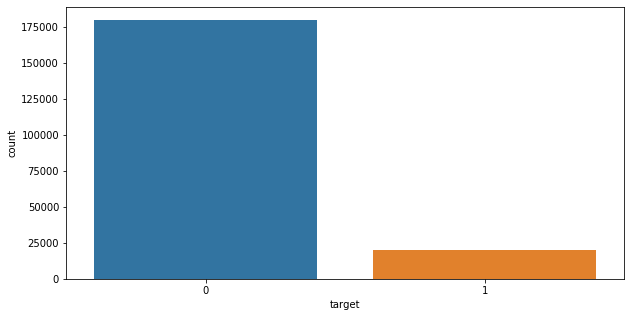

In [10]:
plt.figure(figsize = (10,5))
sns.countplot(train.target)

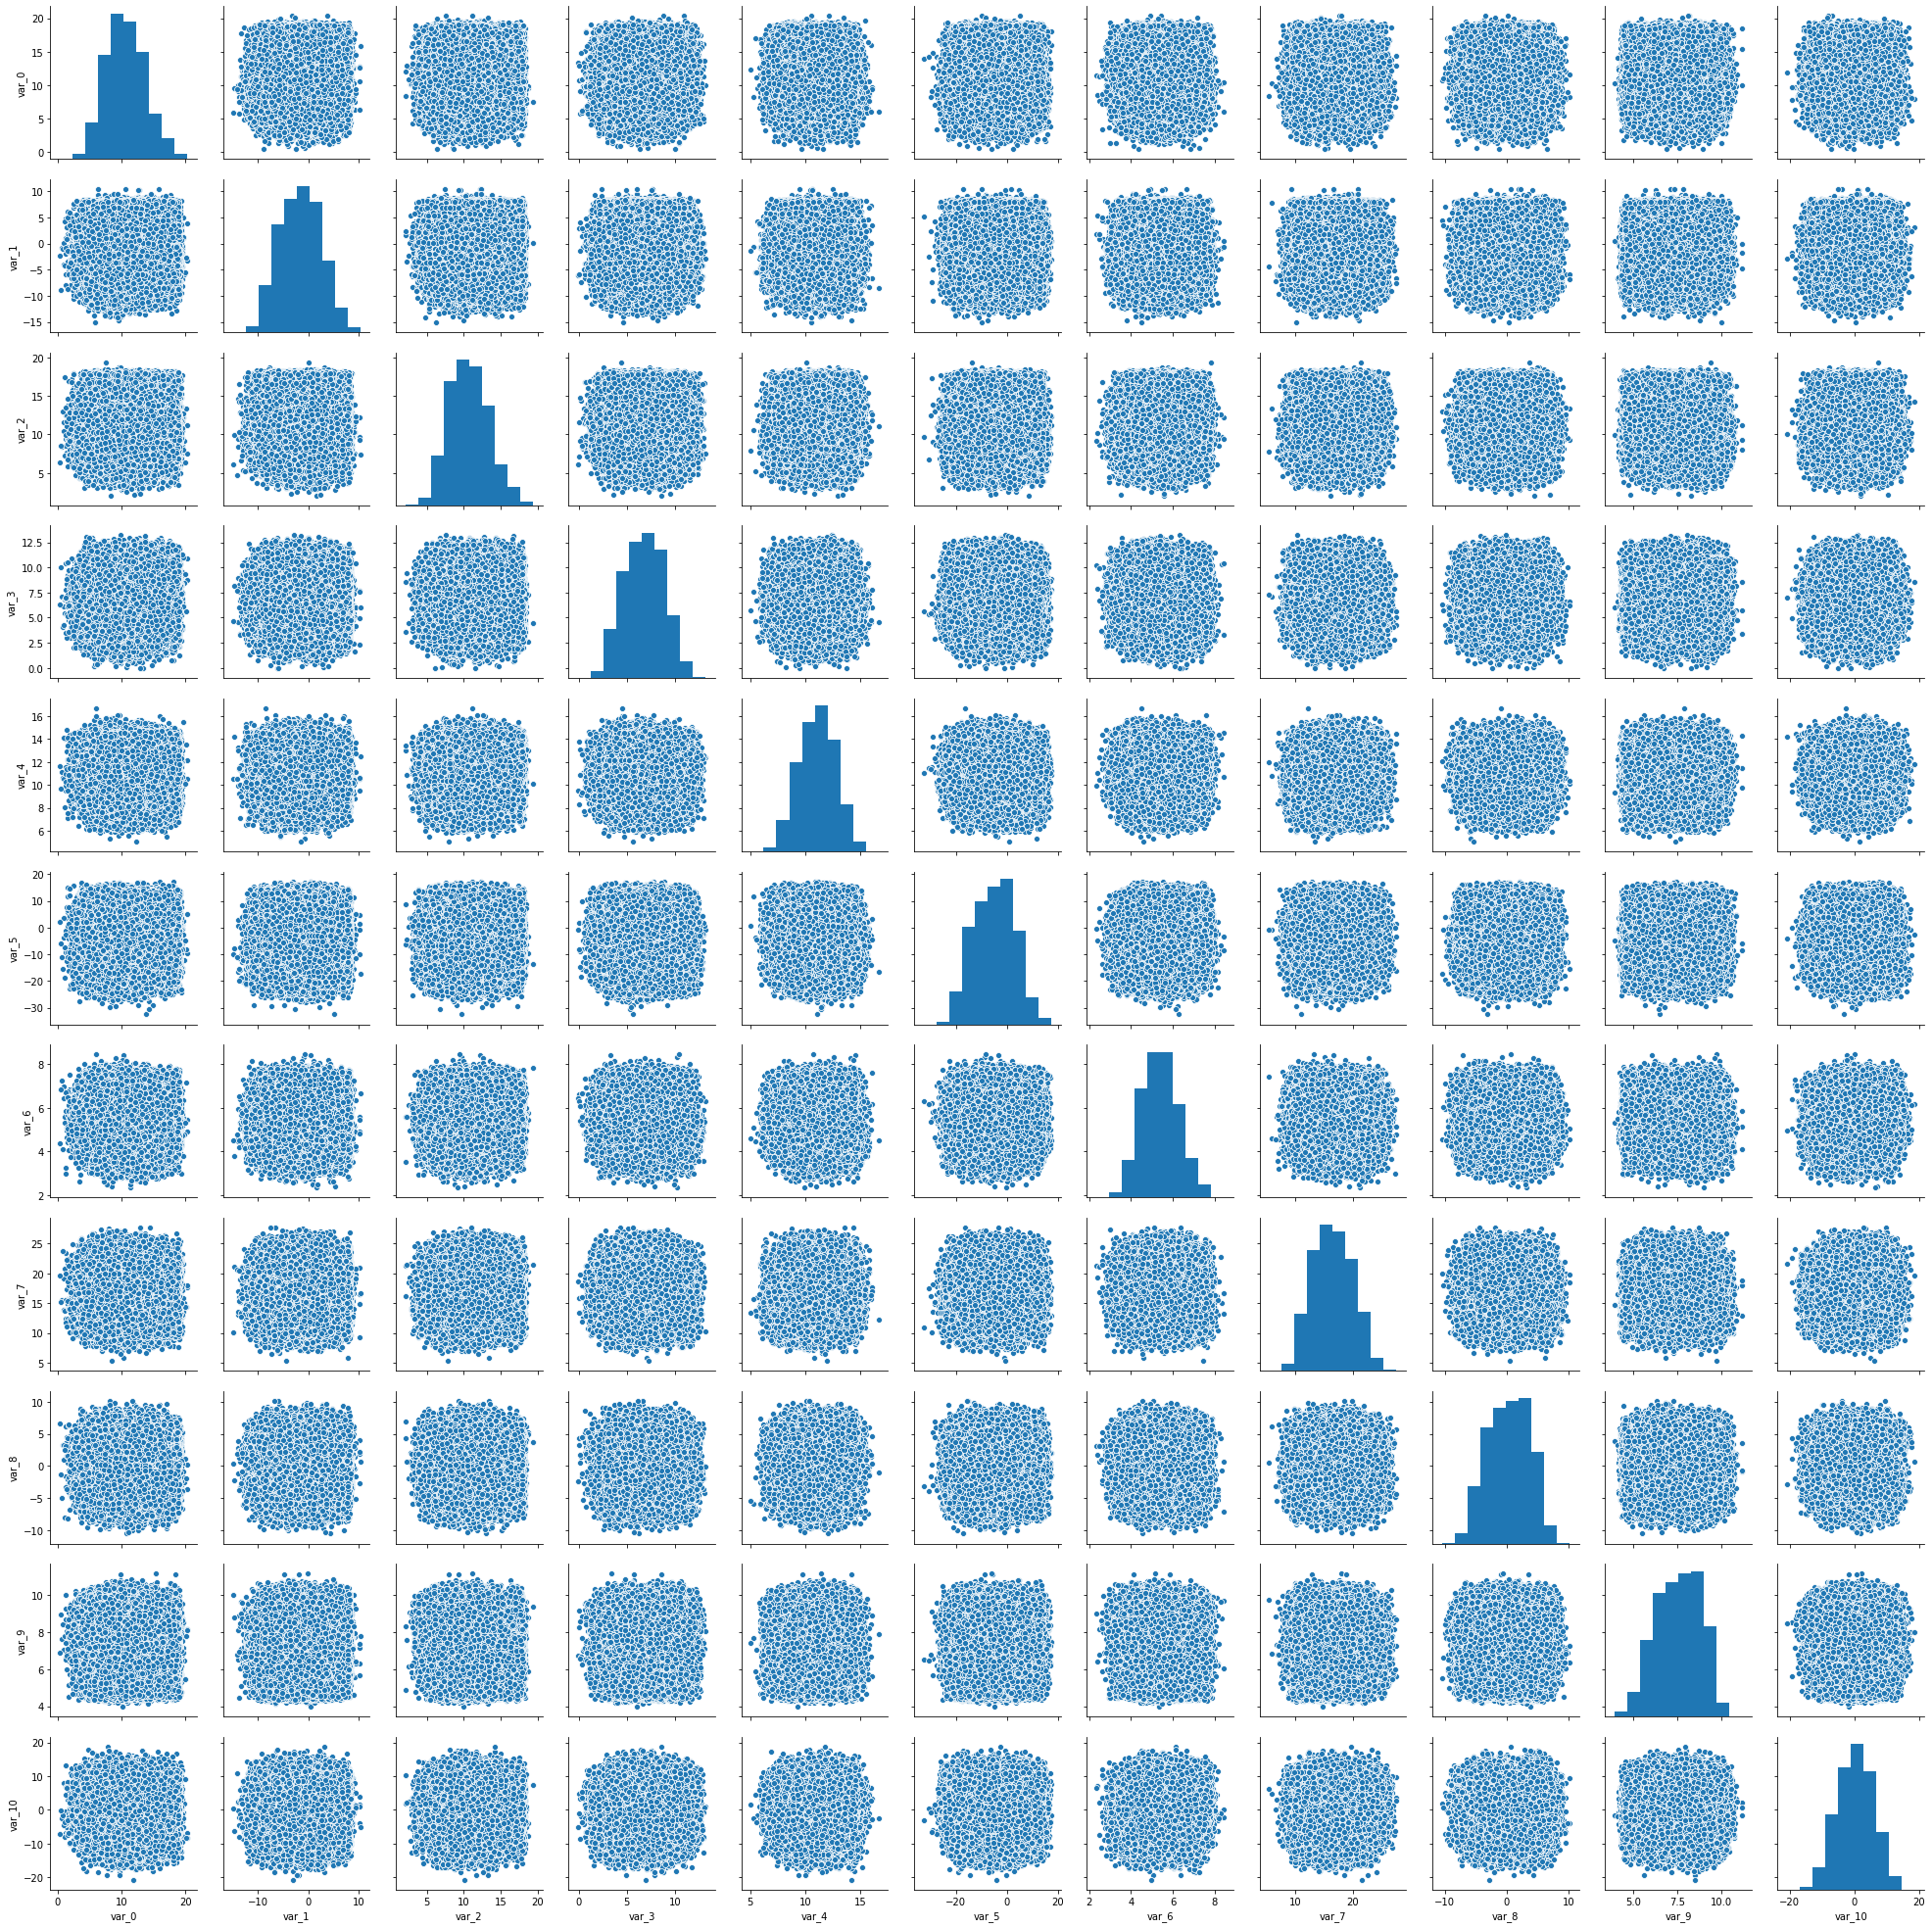

In [143]:
subset = ['var_0','var_1', 'var_2', 
          'var_3', 'var_4', 'var_5', 
          'var_6', 'var_7', 'var_8',
         'var_9', 'var_10']
sns.pairplot(train[subset])

In [12]:
print('Ratio of negative class to the whole dataset:', len(train[train['target']==0]) / len(train))
print('Ratio of positive class to the whole dataset:', len(train[train['target']==1]) / len(train))

Ratio of negative class to the whole dataset: 0.89951
Ratio of positive class to the whole dataset: 0.10049


This indicates that we should stratify the target variable, because the dataset is highly imbalanced.

In [10]:
ID_code = train['ID_code']
X = train.drop(['ID_code', 'target'], axis = 1)
y = train['target']

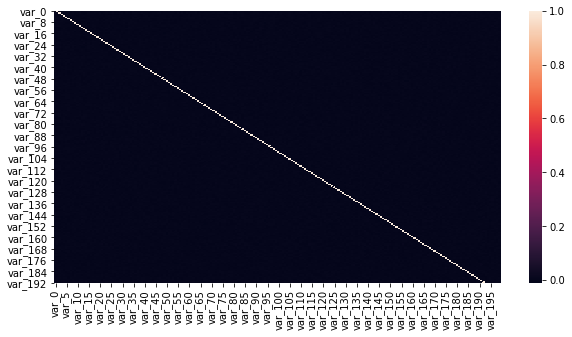

In [14]:
plt.figure(figsize = (10,5))
sns.heatmap(X.corr())

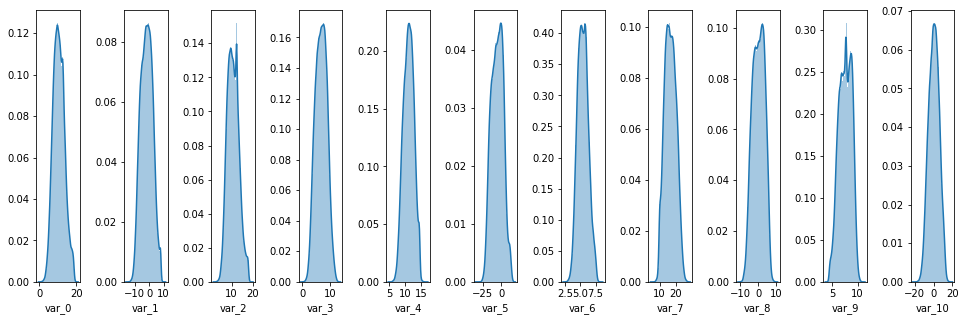

In [202]:
variable_distribution(subset)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, stratify = y)

### Logistic Regression

In [16]:
# Scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns = X_train.columns)

In [17]:
X_train_scaled.head()

var_0     var_1     var_2     var_3     var_4     var_5     var_6  \
0 -0.985639 -1.570668 -0.199285  0.122993  0.772277  0.319999  0.475192   
1  1.081922 -0.618894  1.590879  1.370532 -0.180805 -0.018853  0.872697   
2  1.062620 -1.522345 -1.303634  1.105800 -0.385936 -0.405639 -1.869488   
3 -0.407457  1.007742 -1.053611 -0.989466  1.424354 -1.254073 -0.322354   
4 -0.793142  0.382559 -0.581907  1.844262 -1.313492 -2.077956  0.223178   

      var_7     var_8     var_9  ...   var_190   var_191   var_192   var_193  \
0  1.752888 -0.765126  0.307224  ... -0.389655 -0.036500  0.364830  0.946052   
1 -0.706169  0.865444 -0.635726  ...  0.588198  0.275723 -0.324574  0.496787   
2  1.355875  1.141327  0.120090  ...  0.044551  0.052561 -0.681894 -0.610100   
3  0.592509 -1.983522  1.491757  ...  0.137028 -1.005792  2.429521 -0.865131   
4 -0.548288 -1.537192  1.078898  ...  0.849981 -0.348986  1.571911 -2.140635   

    var_194   var_195   var_196   var_197   var_198   var_199  
0  2.150988 -0.100888  0.034625  0.021213  0.489799  0.976243  
1  0.558838  1.067970  0.614380 -0.784914  0.571665  0.715822  
2  0.583175  0.499837  0.933921 -0.518232 -0.481145  1.831504  
3 -0.554640 -0.610970  1.252508 -0.809355  0.239944 -1.855900  
4  0.964371  1.317170 -1.341673  0.644410 -0.790045  0.429275  

[5 rows x 200 columns]

In [18]:
logreg = LogisticRegression(class_weight = 'balanced', 
                            solver = 'lbfgs') # default parameters (apart from class_weight param)

In [19]:
logreg.fit(X_train_scaled, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [20]:
cross_val_score(logreg, X_train_scaled, y_train, cv = 5)

array([0.78161263, 0.78395522, 0.78201493, 0.77891791, 0.78640994])

In [21]:
y_logreg_preds = cross_val_predict(logreg, X_train_scaled, y_train, cv = 5)

In [22]:
fpr, tpr, thresholds = roc_curve(y_train, y_logreg_preds)

Area Under the Curve score: 0.779143666419864


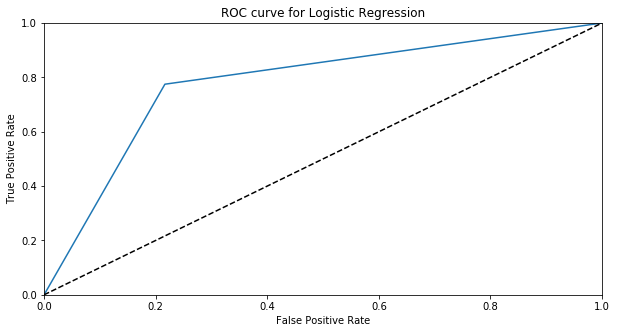

In [25]:
plot_ROC(fpr, tpr, thresholds, 
         model = 'Logistic Regression', 
         actuals=y_train, 
         scores=y_logreg_preds)

In [27]:
precision_score(y_train, y_logreg_preds)

0.28558134442741406

In [28]:
recall_score(y_train, y_logreg_preds)

0.7748403386306253

### Random Forest

In [108]:
forest_clf = RandomForestClassifier(n_estimators = 300,
                                   max_depth = 10,
                                   n_jobs = -1, 
                                   class_weight = 'balanced')

In [109]:
forest_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=300, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [110]:
cross_val_score(forest_clf, 
                X_train, 
                y_train, 
                cv = 5, 
                n_jobs = -1, 
                scoring = 'accuracy')

array([0.89037722, 0.89682836, 0.8941791 , 0.89208955, 0.89652599])

In [121]:
# model_name = 'Random Forest - 300 estimators'
# joblib.dump(forest_clf, model_name)

['Random Forest - 300 estimators']

The results from the CV look okay. Accuracy is about 89% on the Cross Validation. I, for one, am suspicious of these high scores on the CV. Let's dig deeper and see the ROC curve for that model. In order to visualize this we have to use the cross_val_predict to calculate class probabilities (Random Forest does not have the decision_function() method, therefore we have to use the predict proba method, and then use the column with calculated probabilities for the positive class), and then plug in the results to precision_recall_score function from sklearn.

In [111]:
y_probas_rf = cross_val_predict(forest_clf, 
                                X_train, 
                                y_train, 
                                cv = 5, 
                                method = 'predict_proba', 
                                n_jobs=-1)

In [112]:
y_scores_rf = y_probas_rf[:, 1]

In [113]:
fpr, tpr, thresholds = roc_curve(y_train, y_scores_rf)

Area Under the Curve score: 0.8089237933771084


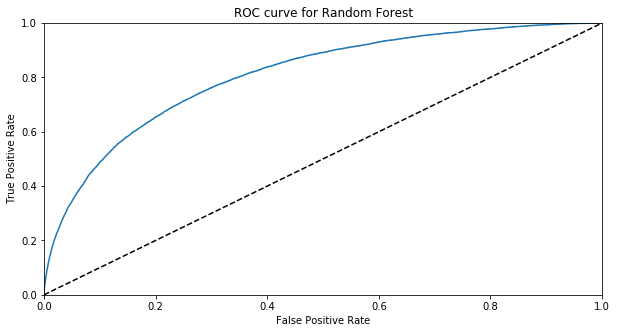

In [114]:
plot_ROC(fpr, tpr, thresholds, 
         model = 'Random Forest', 
         actuals=y_train, 
         scores=y_scores_rf)

The model is performing better than the Logistic Regression. However, in order to achieve better performance, one has to set the n_estimators parameter to a big number (here I used 300 estimators)

In [115]:
y_train_preds = cross_val_predict(forest_clf, 
                                  X_train, 
                                  y_train, 
                                  n_jobs = -1,
                                  cv = 5)

In [116]:
precision_score(y_train, y_train_preds)

0.46451830226813384

In [117]:
recall_score(y_train, y_train_preds)

0.3072181791177781

In [118]:
error_matrix = conf_matr_df(y_train, y_train_preds)
error_matrix

0     1
0  115765  4769
1    9329  4137

As was suspected, the model can easily recognize the negative class, but has troubles when it comes to predicting positive class, which is of course a direct result of how imbalanced the data set is.

Below there is an excerpt of the predicted probabilites (output of the Random Forest predict_proba()) for the positive class.

In [122]:
y_probas_rf[:, 1]

array([0.39913835, 0.5325308 , 0.52126772, ..., 0.43935051, 0.46871106,
       0.35593762])

In [123]:
feature_names = X_train.columns

In [124]:
feature_names

Index(['var_0', 'var_1', 'var_2', 'var_3', 'var_4', 'var_5', 'var_6', 'var_7',
       'var_8', 'var_9',
       ...
       'var_190', 'var_191', 'var_192', 'var_193', 'var_194', 'var_195',
       'var_196', 'var_197', 'var_198', 'var_199'],
      dtype='object', length=200)

In [125]:
feats = {}

for feature, importance in zip(feature_names, 
                               forest_clf.feature_importances_):
    feats[feature] = importance

In [126]:
feature_importances = pd.DataFrame.from_dict(feats, orient = 'index').\
rename(columns={0: 'Gini'})

In [127]:
top10 = feature_importances.sort_values(by = 'Gini', ascending=False)[:10] # Selecting top10 features

Text(0.5, 1.0, 'Top 10 Features')

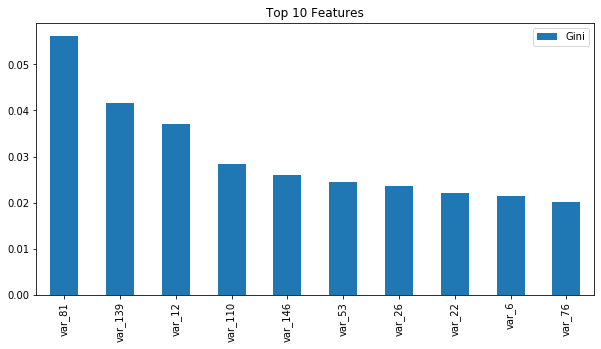

In [128]:
top10.plot(kind = 'bar', figsize = (10, 5))
plt.title('Top 10 Features')

In [206]:
best_feats = []

for i in top10.index:
    best_feats.append(i)

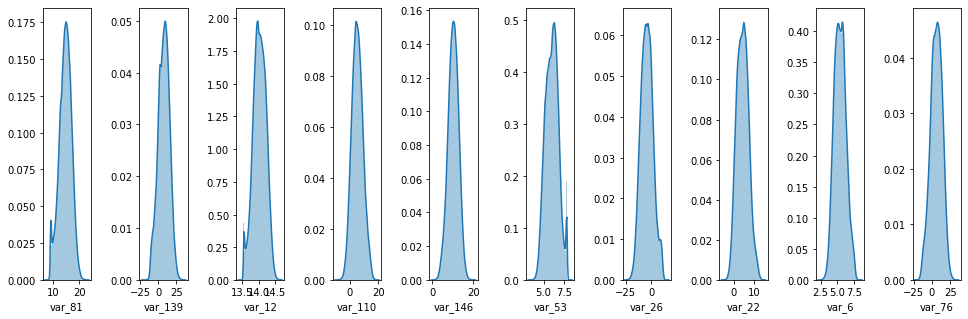

In [208]:
variable_distribution(best_feats)

### Grid Search (3-fold CV)

Even though I am not a big fan of the Grid Search as a concept, I thought that I might as well give it a shot and see what kind of results would I get.

In [85]:
param_grid = [
    {'n_estimators': [10,30,50,70],
    'max_depth': [10,20,30,40],
    'class_weight': ['balanced'],
    'n_jobs': [-1]}
]

In [86]:
grid_search = GridSearchCV(forest_clf, param_grid, n_jobs = -1)

In [87]:
grid_search.fit(X_train, y_train)

/Users/januszpolowczyk/Documents/Santander/env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=10,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=30, n_jobs=-1,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                

In [91]:
for mean_score, param in zip(grid_search.cv_results_['mean_test_score'], 
                             grid_search.cv_results_['params']):
    print(mean_score, param)

0.8312761194029851 {'class_weight': 'balanced', 'max_depth': 10, 'n_estimators': 10, 'n_jobs': -1}
0.8708731343283582 {'class_weight': 'balanced', 'max_depth': 10, 'n_estimators': 30, 'n_jobs': -1}
0.8833731343283582 {'class_weight': 'balanced', 'max_depth': 10, 'n_estimators': 50, 'n_jobs': -1}
0.8879925373134329 {'class_weight': 'balanced', 'max_depth': 10, 'n_estimators': 70, 'n_jobs': -1}
0.8977611940298508 {'class_weight': 'balanced', 'max_depth': 20, 'n_estimators': 10, 'n_jobs': -1}
0.8995597014925373 {'class_weight': 'balanced', 'max_depth': 20, 'n_estimators': 30, 'n_jobs': -1}
0.8995298507462687 {'class_weight': 'balanced', 'max_depth': 20, 'n_estimators': 50, 'n_jobs': -1}
0.8995149253731344 {'class_weight': 'balanced', 'max_depth': 20, 'n_estimators': 70, 'n_jobs': -1}
0.899276119402985 {'class_weight': 'balanced', 'max_depth': 30, 'n_estimators': 10, 'n_jobs': -1}
0.8995223880597015 {'class_weight': 'balanced', 'max_depth': 30, 'n_estimators': 30, 'n_jobs': -1}
0.899507462

In [101]:
best_model = grid_search.best_params_

In [106]:
for val in best_model:
    print(val + ':', best_model[val])

class_weight: balanced
max_depth: 20
n_estimators: 30
n_jobs: -1


In [108]:
grid_search.best_estimator_.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=30, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [112]:
y_probas_grid_rf = cross_val_predict(grid_search.best_estimator_, 
                                X_train, 
                                y_train, 
                                cv = 5, 
                                method = 'predict_proba', 
                                n_jobs=-1)

In [113]:
y_scores_grid_rf = y_probas_grid_rf[:, 1]

In [114]:
fpr, tpr, thresholds = roc_curve(y_train, y_scores_grid_rf)

Area Under the Curve score: 0.6662386638580057


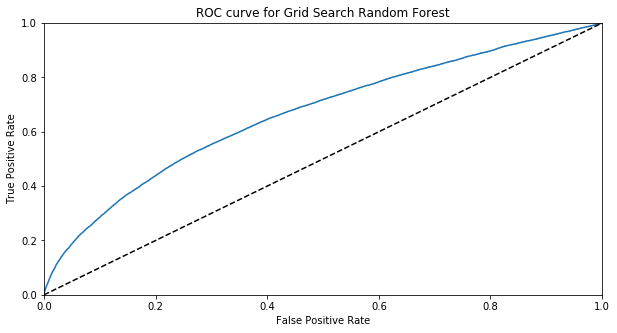

In [115]:
plot_ROC(fpr, tpr, thresholds, actuals = y_train, scores = y_scores_grid_rf, model = 'Grid Search Random Forest') 

Interesting. The auROC is smaller for the supposedly best model (based on GridSearchCV) than the model that I started with. The plot confirms this intuition as well

### Measuring the error of the Random Forest

In [102]:
k_fold = KFold(n_splits = 5, shuffle = True, random_state = 42)

In [103]:
forest_train_scores = []
forest_cv_scores = []
KFoldsForestpreds = pd.DataFrame(data = [],
                                 index = y_train.index,
                                 columns= [0,1])

In [130]:
for train_idx, cv_idx in k_fold.split(np.zeros(len(X_train)),
                                     y_train.ravel()):
    X_train_fold, X_cv_fold = X_train.iloc[train_idx, :], \
                              X_train.iloc[cv_idx, :]
    y_train_fold, y_cv_fold = y_train.iloc[train_idx], \
                              y_train.iloc[cv_idx]
    
    forest_clf.fit(X_train_fold, y_train_fold)
    loglossTrain = log_loss(y_train_fold,
                           forest_clf.predict_proba(X_train_fold)[:, 1]) # Positive Class column
    forest_train_scores.append(loglossTrain)
    
    KFoldsForestpreds.loc[X_cv_fold.index, :] = forest_clf.predict_proba(X_cv_fold)
    loglossCV = log_loss(y_cv_fold,
                        KFoldsForestpreds.loc[X_cv_fold.index, 1])
    forest_cv_scores.append(loglossCV)
    
    print('Training Log Loss:', loglossTrain)
    print('CV Log Loss:', loglossCV)
    
loglossForest = log_loss(y_train, KFoldsForestpreds.loc[:, 1])
print('Random Forest Log Loss:', loglossForest)
    

Training Log Loss: 0.5295404750673378
CV Log Loss: 0.5568441418002295
Training Log Loss: 0.5300980587720994
CV Log Loss: 0.5566866839166523
Training Log Loss: 0.5290703189870057
CV Log Loss: 0.5556429384746482
Training Log Loss: 0.5299058574286714
CV Log Loss: 0.5570788594372437
Training Log Loss: 0.5292424290161056
CV Log Loss: 0.5563799878466896
Random Forest Log Loss: 0.5565265222950927


The error function (which I chose to be Log Loss) for the Random Forest is very large. In fact it may be larger than the Logistic Regression model, which I chose in the beginning. One of the possible explanations for this, is that Random Forest (or generally tree-based models) are "looking" for **orthogonal** decision boundaries (parallel to the y-axis), which in the case of this data set may not be true.

In [105]:
logreg_train_scores = []
logreg_cv_scores = []
KFoldsLogRegpreds = pd.DataFrame(data = [],
                                 index = y_train.index,
                                 columns= [0,1])

In [107]:
### Logistic Regression Log Loss used for comparison with the Random Forest


for train_idx, cv_idx in k_fold.split(np.zeros(len(X_train)),
                                     y_train.ravel()):
    X_train_fold, X_cv_fold = X_train.iloc[train_idx, :], \
                              X_train.iloc[cv_idx, :]
    y_train_fold, y_cv_fold = y_train.iloc[train_idx], \
                              y_train.iloc[cv_idx]
    
    logreg.fit(X_train_fold, y_train_fold)
    loglossTrain = log_loss(y_train_fold,
                           logreg.predict_proba(X_train_fold)[:, 1]) # Positive Class column
    logreg_train_scores.append(loglossTrain)
    
    KFoldsLogRegpreds.loc[X_cv_fold.index, :] = logreg.predict_proba(X_cv_fold)
    loglossCV = log_loss(y_cv_fold,
                        KFoldsLogRegpreds.loc[X_cv_fold.index, 1])
    logreg_cv_scores.append(loglossCV)
    
    print('Training Log Loss:', loglossTrain)
    print('CV Log Loss:', loglossCV)
    
loglossLogReg = log_loss(y_train, KFoldsLogRegpreds.loc[:, 1])
print('Logistic Regression Log Loss:', loglossLogReg)
    

/Users/januszpolowczyk/Documents/Santander/env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Training Log Loss: 0.4714237183281735
CV Log Loss: 0.47792237355664446


/Users/januszpolowczyk/Documents/Santander/env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Training Log Loss: 0.47242172083107187
CV Log Loss: 0.47695154016173874


/Users/januszpolowczyk/Documents/Santander/env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Training Log Loss: 0.47347271626285015
CV Log Loss: 0.4701759168741396


/Users/januszpolowczyk/Documents/Santander/env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Training Log Loss: 0.4712875743354919
CV Log Loss: 0.47329046894922566
Training Log Loss: 0.4702226677834174
CV Log Loss: 0.46904597172696066
Logistic Regression Log Loss: 0.4734772542537418


/Users/januszpolowczyk/Documents/Santander/env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


### LightGBM

In [82]:
training_data = lgb.Dataset(X_train, label = y_train)

In [51]:
validation_data = training_data.create_valid('validset.svm')

In [83]:
training_data

In [162]:
params = {
    'objective': 'binary',
    'num_leaves': 3,
    'metric': 'auc',
    'max_depth': -1,
    'learning_rate': 0.05
}

In [163]:
num_round = 2000
bst = lgb.train(params, training_data, num_round)

In [164]:
for feature in bst.feature_importance():
    print(X_train.iloc[:, feature])

94546     17.4727
191088    16.0609
129066    20.6554
34362      5.2417
44843     17.3154
           ...   
40827     18.3198
97142      0.1043
144988     9.2611
88753     17.4084
110635    11.8093
Name: var_41, Length: 134000, dtype: float64
94546     12.0196
191088    11.5271
129066    12.2013
34362     12.6289
44843     11.0357
           ...   
40827     11.4394
97142     10.4841
144988    10.2796
88753     11.8356
110635    10.7598
Name: var_42, Length: 134000, dtype: float64
94546     -3.4318
191088   -12.5062
129066   -14.1964
34362    -12.2140
44843    -16.6624
           ...   
40827      0.2142
97142     -8.4232
144988   -13.7522
88753     -4.5269
110635    -0.9072
Name: var_40, Length: 134000, dtype: float64
94546     2.9753
191088   -4.2895
129066    2.7648
34362    -3.4852
44843    -5.6016
           ...  
40827    -0.7394
97142    -1.6760
144988    0.1194
88753    -7.3141
110635   -2.3186
Name: var_1, Length: 134000, dtype: float64
94546     -8.5227
191088    -1.6836
1290

Name: var_40, Length: 134000, dtype: float64
94546     6.2672
191088    4.6504
129066    7.0945
34362     6.1360
44843     4.8124
           ...  
40827     5.6796
97142     5.0248
144988    5.9865
88753     5.7717
110635    4.9125
Name: var_28, Length: 134000, dtype: float64
94546     20.6186
191088    13.1764
129066     1.1743
34362      9.6430
44843     17.9067
           ...   
40827     15.3257
97142     22.0278
144988    16.0828
88753     10.9825
110635     7.8724
Name: var_44, Length: 134000, dtype: float64
94546     -3.0095
191088    -2.7620
129066   -19.6224
34362     -6.0007
44843    -11.4427
           ...   
40827    -12.6472
97142    -23.9712
144988   -19.1395
88753     -1.8190
110635    -8.4172
Name: var_30, Length: 134000, dtype: float64
94546     10.2360
191088     5.1077
129066     7.6942
34362     12.5074
44843     12.0667
           ...   
40827     18.2934
97142     11.1337
144988    14.9913
88753     12.3768
110635    10.1184
Name: var_0, Length: 134000, dtype: flo

Name: var_38, Length: 134000, dtype: float64
94546     21.7021
191088    19.6305
129066     3.9587
34362      9.7422
44843     19.5465
           ...   
40827      7.3573
97142     15.0344
144988    20.1706
88753     15.4109
110635     5.0573
Name: var_20, Length: 134000, dtype: float64


In [165]:
bst.feature_importance()

array([41, 42, 40,  1,  5, 27, 47,  0,  7, 42,  0, 13, 47, 44,  1,  4,  0,
        0, 32,  1, 14, 47, 49, 12, 24,  2, 44,  0, 16,  0,  0, 18, 28, 43,
       48, 30, 31,  4,  0,  0, 40,  0,  0, 24, 36, 17,  0,  0, 29, 30,  1,
       21, 23, 51,  4, 12, 30,  5, 18,  1,  0,  0,  5,  0,  0,  0, 17, 33,
        1,  3, 20, 28,  7,  0, 10, 28, 47, 10, 41,  0, 42, 49, 19, 11,  0,
       17, 32, 31, 10, 29, 18, 36, 40, 28, 44, 30,  0,  8,  0, 45,  0,  1,
       10,  0, 21, 13, 24, 32, 49, 42, 42, 22, 16,  2, 16, 34, 16,  0, 32,
       23,  0, 36, 38, 36,  0, 20,  0, 36, 21,  0, 30, 25, 19, 44, 13, 19,
        0, 25,  7, 48,  9, 29,  8,  3, 13, 26, 42, 35, 38, 35, 23, 22,  1,
        0, 39, 35, 10, 27,  0,  0,  0,  0, 25, 25, 41, 42, 46, 29,  6, 41,
       38,  8, 31, 35, 46, 18,  0, 33, 11, 34, 30,  5,  0,  0, 41,  0, 22,
        9, 28,  0, 41, 37, 31, 10, 19, 22, 17, 29, 38, 20], dtype=int32)

In [166]:
lgb.cv(params, training_data, num_round, nfold=5)

{'auc-mean': [0.5764221722735047,
  0.6044530863034752,
  0.6115271217209208,
  0.6178205572993328,
  0.6219199317060449,
  0.6303535114353395,
  0.6389446999689734,
  0.6452350548142974,
  0.6512489685644225,
  0.6540356769431126,
  0.6599555199654068,
  0.6633350098564634,
  0.6694769361306043,
  0.6745078390034005,
  0.6793537033069316,
  0.6820573816865867,
  0.684235400941962,
  0.6881539038931036,
  0.6904459072721284,
  0.6912660728724248,
  0.6941334596155385,
  0.6962010323005,
  0.6987673317093955,
  0.7004744676123954,
  0.7031995132327102,
  0.704915819285137,
  0.7082027133602814,
  0.7099536569003316,
  0.7122139700913808,
  0.7143015643620646,
  0.7151694631774488,
  0.7172628778929602,
  0.7190716431429311,
  0.7208554193631624,
  0.7219104388630688,
  0.7232990825360839,
  0.7247615148840147,
  0.7274806122657064,
  0.7284834767179847,
  0.72982716096069,
  0.7324085417431151,
  0.7336970124515432,
  0.7355678232504641,
  0.7373691415957264,
  0.7387184927550816,
  0.7

In [167]:
y_lgbm_preds = bst.predict(X_test)

In [168]:
fpr, tpr, thresholds = roc_curve(y_test, y_lgbm_preds)

Area Under the Curve score: 0.8897350010988281


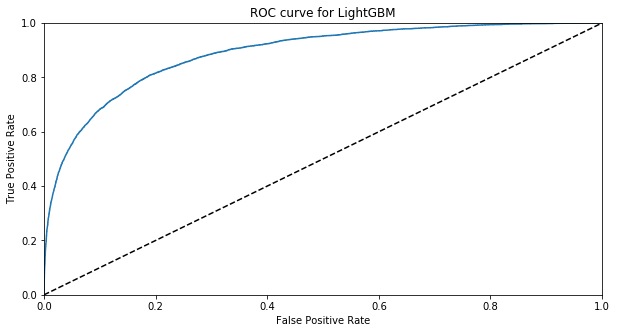

In [169]:
plot_ROC(fpr, tpr, thresholds, actuals = y_test, scores = y_lgbm_preds, model = 'LightGBM')

In [170]:
test_data = pd.read_csv(data_path + '/test.csv')

In [171]:
ID_test = test_data['ID_code']

In [172]:
test_data.drop('ID_code', axis = 1, inplace = True)

In [173]:
final_preds = bst.predict(test_data)

In [174]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_lgbm_preds)

In [175]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label = 'Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label = 'Recall')
    plt.xlabel('Threshold')
    plt.legend(loc = 'best')
    plt.ylim([0,1])

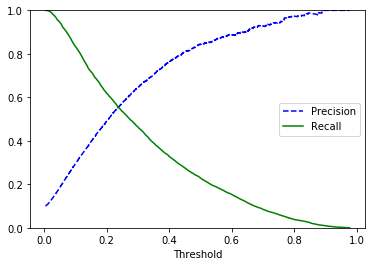

In [176]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

In [178]:
final_preds

array([0.14008801, 0.28135993, 0.18408036, ..., 0.012295  , 0.11736237,
       0.12231553])

In [179]:
predictions_binary = []


for i in final_preds:
    if i > .5:
        predictions_binary.append(1)
    else:
        predictions_binary.append(0)

In [180]:
predictions_binary = pd.Series(predictions_binary)

In [181]:
final_preds = pd.concat([ID_test, predictions_binary], axis = 1)

In [182]:
final_preds.columns = ['ID_code', 'target']

In [183]:
final_preds.to_csv('Santander_predictions_using_LGBM_different_LR.csv', index = False)